# Assignment 6: Neuroevolution
In our last assignment, we explored the week's major idea (representation and genetic encoding) in a more realistic application in the Traveling Salesman Problem.  This week we'll follow that trend and explore the ideas around mutation rates and measuring diversity in the setting of evoliving artificial neural networks (Neuroevolution).  While neuroevolution really shines outside of standard machine learning benchmarks, for the sake of simplicity, we'll use one of the most basic benchmarks for neural networks, classification of handwritten digits in MNIST.  

In [2]:
# imports
import numpy as np
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import scikits.bootstrap as bootstrap
import warnings
warnings.filterwarnings('ignore') # Danger, Will Robinson! (not a scalable hack, and may surpress other helpful warning other than for ill-conditioned bootstrapped CI distributions)

import scipy.stats # for finding statistical significance

import time

I've taken the liberty to preprocess MNIST for you by deskewing (standard preprocessing step to straigthen tilted images) and downscaling the images from `28x28` to `14x14` to try and keep out genome size down (at the cost of losing some resolution/information in the images), split out the labels (turning them into one-hot encodings), and separating the train and test sets.  If you aren't familiar with machine learning practices like this, don't worry about it -- just load the datasets below.

*Note:* This dataset contains 60,000 training examples, and 10,000 testing examples.  This is likely far overkill for what we need, so if your machine is struggling with the size of the dataset, feel free to use only a small portion of the training examples/labels provided (doing so didn't effect runtime much on my laptop, but your mileage may vary)

In [3]:
train_x = np.loadtxt("train_x.csv", delimiter=',')
test_x = np.loadtxt("test_x.csv", delimiter=',')
train_y = np.loadtxt("train_y.csv", delimiter=',')
test_y = np.loadtxt("test_y.csv", delimiter=',')

Let's take a look at the images!

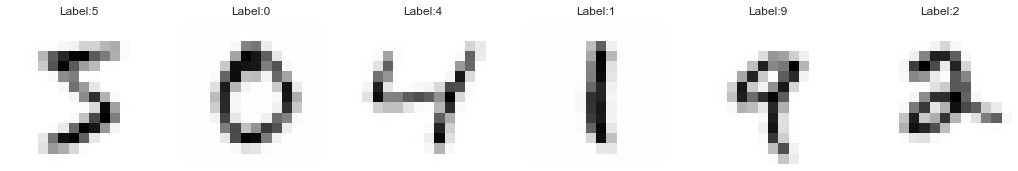

In [5]:
# This is what the image looks like
num_images = 6
fig, axs = plt.subplots(1, num_images, figsize=(3*num_images, 3), sharey=True)
for i in range(num_images):
    axs[i].imshow(train_x[i].reshape(14,14)) # we will keep the images flat to easily feed them into the neural network, but we need them back in a square shape to visualize
    axs[i].grid(False)
    axs[i].axis('off')
    axs[i].set_title("Label:"+str(np.argmax(train_y[i]))) # the argmax takes out one-hot encoding and turns it into a readable label

### Q1: Implementation
Our individual solutions this week will be (again keeping things overly simplistic) single-layer neural networks.  These networks are defined by a single weight matrix with input dimenion of the size of the flattened image (`14*14=196`) and output dimension of the size of the number of possible classes (`10`).  Feel free to implement the genome as the weight matrix, or simply as a flattened float vector of size `1960`.  

In [6]:
class Individual:
    
    def __init__(self, fitness_function, genome_length):
        self.genome = np.random.rand(14*14*10)*2-1
#         self.genome = np.random.normal(loc = 0, scale = 1, size = genome_length)
        self.fitness_function = fitness_function
        self.fitness = 0
        
    def eval_fitness(self):
        self.fitness= self.fitness_function(self.genome)

There are two main ways to measure the performance of a neural network, loss and accuracy.  For the sake of intuition, let's use accuracy here, but I'm providing the implementaition of loss just in case you want to play around with it as well (thought returning the negative of the loss, as the smaller magnitudes are better so this allows us to continue going "uphill" if we do ever choose to optimize for loss).  

As we haven't covered neural networks, I'm also providing the implementation of a single layer neural network (desite its apparent simplicity compared to mult-layer networks) in the fitness function below.  

In [7]:
def accuracy(output, y):
    return np.sum(np.isclose(np.argmax(output,axis=1),np.argmax(y,axis=1)))/y.shape[0]

def loss (output, y):
    return -np.sum(np.square(output-y))/y.shape[0]

def neural_network_fitness(weights,x=train_x,y=train_y):
    weight_matrix = weights.reshape((14*14,10)) 
    output = x.dot(weight_matrix)
    return accuracy(output,y)

### Q1b: Real-valued mutation

In class, we've only alluded indrectly to mutating vectors of floats as genomes (like neural network weights).  Let's play around with the implmentations of these.  For simplicity, we'll ignore crossover for now.  Rather than flipping a given number of bits, let's try adding a small random value to each gene's value by adding `(np.random.rand(genome_length)*2-1)*mutation_size` to the genome. This takes a uniform distribution, normalizes it to be between -1 and 1, then scales it by some `mutation_size` scaling factor that you can pass into your `evolutionary_algorithm` function.  

### Q1c: Diversity Tracking

In addition to keeping track of the best genome, and fitness at each generation, let's also record the diversity of the population at each generation.  The metric we talked about most in class was measuring genotypic diversity with the average standard deviation of the distribution across the population of the values for each gene.  

In [8]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, mutation_size=0.1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        mutation_size: (float) scaling parameter of the magnitidue of mutations for floating point vectors
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
        solutions_over_time: (numpy array) track record of the top genome value at each generation
        diversity_over_time: (numpy array) track record of the population genetic diversity at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    best_accuracy = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length))
    diversity_over_time = np.zeros(total_generations)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            # N/A

            # mutation
            for this_child in [child1,child2]:
                this_child.genome += (np.random.rand(genome_length)*2-1)*mutation_size
#                 this_child.genome += np.random.normal(loc = 0, scale = mutation_size, size = genome_length)
                this_child.genome = np.minimum(np.maximum(this_child.genome,-1),1)
        
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
                
#         print(generation_num, solution_fitness, best_accuracy, diversity)
        
    return fitness_over_time, solutions_over_time, diversity_over_time

### Q2: Experimentation

Due to the high dimensionality of this problem, the runs are a bit slower than before, so let's keep the scale small on this with just `50` generations and `5` repitions.  Hopefully this keeps things managable from a runtime persepctive (runs in a little over 30 seconds for each repition, or a little under 3 minutes for all 5, on my machine).  Let's use a mutation size of `1.0`, the same `50` parents and `50` children settings from last week, and a tournament size of `20`, choosing `10` winners.

*Hint:* If this still takes to long to run on your machine (especially while debugging/exploring code), feel free to run smaller test runs first by reducing the number of generations for the runs, plotting without bootstrapping, etc.

In [9]:
experiment_results = {}
solutions_results = {}
diversity_results = {}

In [12]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 1.0
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 10

for run_name in ["mutate_uniform_1.0_tournamen_20_choose_10"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_1.0_tournamen_20_choose_10 0 21.468574047088623 0.4050666666666667
mutate_uniform_1.0_tournamen_20_choose_10 1 21.57516646385193 0.39031666666666665
mutate_uniform_1.0_tournamen_20_choose_10 2 21.974435567855835 0.39353333333333335
mutate_uniform_1.0_tournamen_20_choose_10 3 21.93344020843506 0.3577166666666667
mutate_uniform_1.0_tournamen_20_choose_10 4 22.129838228225708 0.3976166666666667


### Q2b: Modifying Selection Pressure
To create conditions which vary the amount of selection pressure, please also run the above runs varying the number of tournament winners to be `1` and `5` (in addition to the `10` you alredy ran).

In [10]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 1.0
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 5

for run_name in ["mutate_uniform_1.0_tournamen_20_choose_5"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_1.0_tournamen_20_choose_5 0 21.447892904281616 0.4386833333333333
mutate_uniform_1.0_tournamen_20_choose_5 1 21.514994859695435 0.4460166666666667
mutate_uniform_1.0_tournamen_20_choose_5 2 22.57013726234436 0.4781
mutate_uniform_1.0_tournamen_20_choose_5 3 21.651416301727295 0.40058333333333335
mutate_uniform_1.0_tournamen_20_choose_5 4 22.756819248199463 0.4363666666666667


In [22]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 1.0
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 1

for run_name in ["mutate_uniform_1.0_tournamen_20_choose_1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_1.0_tournamen_20_choose_11 0 21.833979845046997 0.40113333333333334
mutate_uniform_1.0_tournamen_20_choose_11 1 21.80709481239319 0.41951666666666665
mutate_uniform_1.0_tournamen_20_choose_11 2 21.11648154258728 0.44093333333333334
mutate_uniform_1.0_tournamen_20_choose_11 3 21.03928542137146 0.4357
mutate_uniform_1.0_tournamen_20_choose_11 4 22.078652143478394 0.4353


### Q2c: Visualization
Like last time, please plot the bootstrapped fitness values over time for all 3 treatments.

In [11]:
def plot_mean_and_bootstrapped_ci_over_time(input_data = None, name = "change me", x_label = "change me", y_label="change me", y_limit = None, plot_bootstrap = True):
    """
    
    parameters: 
    input_data: (numpy array of shape (max_k, num_repitions)) solution metric to plot
    name: (string) name for legend
    x_label: (string) x axis label
    y_label: (string) y axis label
    
    returns:
    None
    """

    fig, ax = plt.subplots() # generate figure and axes

    if isinstance(name, str): name = [name]; input_data = [input_data]

    # for this_input_data, this_name in zip(input_data, name):
    for this_name in name:
        print("plotting",this_name)
        this_input_data = input_data[this_name]
        total_generations = this_input_data.shape[1]

        if plot_bootstrap:
            boostrap_ci_generation_found = np.zeros((2,total_generations))
            for this_gen in range(total_generations):
                if this_gen%10==0: print(this_gen)
                boostrap_ci_generation_found[:,this_gen] = bootstrap.ci(this_input_data[:,this_gen], np.mean, alpha=0.05)


        ax.plot(np.arange(total_generations), np.mean(this_input_data,axis=0), label = this_name) # plot the fitness over time
        if plot_bootstrap:
            ax.fill_between(np.arange(total_generations), boostrap_ci_generation_found[0,:], boostrap_ci_generation_found[1,:],alpha=0.3) # plot, and fill, the confidence interval for fitness over time
        ax.set_xlabel(x_label) # add axes labels
        ax.set_ylabel(y_label)
        if y_limit: ax.set_ylim(y_limit[0],y_limit[1])
        plt.legend(loc='best'); # add legend

plotting mutate_uniform_1.0_tournamen_20_choose_10
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_5
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_11
0
10
20
30
40


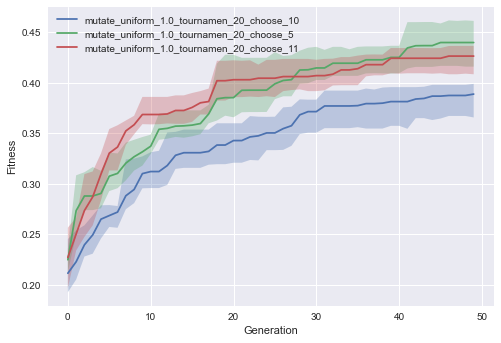

In [25]:
# plot fitness over time
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = ["mutate_uniform_1.0_tournamen_20_choose_10","mutate_uniform_1.0_tournamen_20_choose_5","mutate_uniform_1.0_tournamen_20_choose_11"], x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)

### Q3: Visualizing Diversity
Please also plot the diveristy of our population over evolutionary time.  

plotting mutate_uniform_1.0_tournamen_20_choose_10
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_5
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_11
0
10
20
30
40


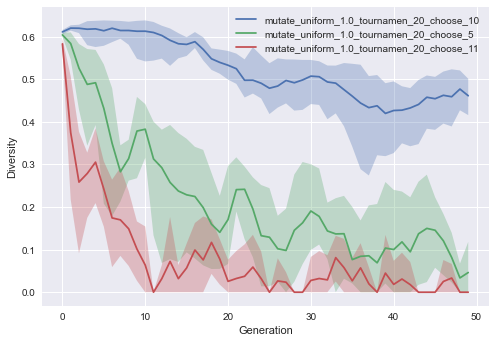

In [26]:
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = ["mutate_uniform_1.0_tournamen_20_choose_10","mutate_uniform_1.0_tournamen_20_choose_5","mutate_uniform_1.0_tournamen_20_choose_11"], x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q3b: Analysis
What do you notice about the diveristy over time?  Is this what you expected to tradeoff exploration and exploitation -- and how it related to fitness?  

**insert text here**

### Q4: Generalization to Test Datasets
Whenever doing classification, it's good to make sure that your algorithm isn't overfitting to the training data.  Based on your intuition about diversity and overfitting, what do you expect this relationship to look like? 

**insert text here**

### Q5: Evaluating Test Accuracy
Since we already have test data loaded in above, let's evaluate your already trained algorithms (using your saved best-solution-so-far genomes at each generation) to see how test fitness tracks with the training fitness.  

Please implement a script which calcualtes the test accuracy of the solutions over time below.

*Hin:* Look for where the training set is used during fitness evaluation during training for ideas of what functions/syntax to use

In [33]:
test_accuracy_results = {}

def calc_test_accuracy_over_time(name = None):
    for run_name in name:
        test_accuracy_results[run_name] = np.zeros((num_runs, total_generations))
        for run_num in range(len(solutions_results[run_name])):
            for gen_num in range(total_generations):
                test_accuracy_results[run_name][run_num, gen_num] = neural_network_fitness(solutions_results[run_name][run_num, gen_num,:],x=test_x,y=test_y)      

plotting mutate_uniform_1.0_tournamen_20_choose_10
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_5
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_11
0
10
20
30
40


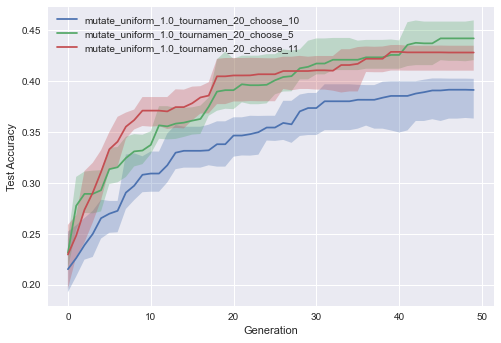

In [37]:
calc_test_accuracy_over_time(name = ["mutate_uniform_1.0_tournamen_20_choose_10","mutate_uniform_1.0_tournamen_20_choose_5","mutate_uniform_1.0_tournamen_20_choose_11"])
plot_mean_and_bootstrapped_ci_over_time(input_data = test_accuracy_results, name = ["mutate_uniform_1.0_tournamen_20_choose_10","mutate_uniform_1.0_tournamen_20_choose_5","mutate_uniform_1.0_tournamen_20_choose_11"], x_label = "Generation", y_label = "Test Accuracy", plot_bootstrap = True)      

### Q5b: Analysis
What did you find for a relationship between genetic diversity and overfitting to the training set?  Was this what you expected?

**insert text here**

### Q6: Modifying Muation Rates
Next well modify the mutation rate for our algorithm.  Based on the results you see above, and how you expect mutation rate to modify the genetic diveristy of a population, how might you think that increasing or decreasing the mutation rate might effect the different tournament size runs above?

**insert text here**

### Q7: Experimentation
Let's find out!  Let's do a mini grid search on the `mutation_size` and `num_tournament_winners`.  To keep the number of runs down, let's just look at the exteme values of `num_tournament_winners` we had above (`1` and `10`), and run these for a `mutation_size` of `0.5` and `2.0` (in addition to the value of `1.0` we had before).  

*Hint:* This is a good time to double check that your `mutation_size` parameter you implemented above is working correctly (i.e. your results for how it should effect diversity below make sense)

*Note:* This may take some time to run (if each condition is a couple minutes).  Please try debugging code with smaller runs and make sure that if there are errors in along the way, what you've run already is saved and logged (so you don't have to rerun all 10 or 15 mins if you find a bug at the end of your script).  And just use this time to go grab a coffee (or do some reading in your lovely evolutionary computation textbooks)!

In [28]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 2.0
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 10

for run_name in ["mutate_uniform_2.0_tournamen_20_choose_10"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_2.0_tournamen_20_choose_10 0 21.363296270370483 0.36051666666666665
mutate_uniform_2.0_tournamen_20_choose_10 1 21.427942752838135 0.4121166666666667
mutate_uniform_2.0_tournamen_20_choose_10 2 21.334521532058716 0.32555
mutate_uniform_2.0_tournamen_20_choose_10 3 21.646496057510376 0.31325
mutate_uniform_2.0_tournamen_20_choose_10 4 22.27677273750305 0.32925


In [29]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 2.0
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 1

for run_name in ["mutate_uniform_2.0_tournamen_20_choose_1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_2.0_tournamen_20_choose_1 0 22.333617687225342 0.34625
mutate_uniform_2.0_tournamen_20_choose_1 1 23.065034866333008 0.33755
mutate_uniform_2.0_tournamen_20_choose_1 2 21.988997220993042 0.3493833333333333
mutate_uniform_2.0_tournamen_20_choose_1 3 22.02181386947632 0.3395
mutate_uniform_2.0_tournamen_20_choose_1 4 22.235310316085815 0.37403333333333333


In [30]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 0.5
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 1

for run_name in ["mutate_uniform_0.5_tournamen_20_choose_1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_0.5_tournamen_20_choose_1 0 22.253052473068237 0.5187666666666667
mutate_uniform_0.5_tournamen_20_choose_1 1 23.02709197998047 0.5162333333333333
mutate_uniform_0.5_tournamen_20_choose_1 2 23.3645761013031 0.5393166666666667
mutate_uniform_0.5_tournamen_20_choose_1 3 22.458110570907593 0.46486666666666665
mutate_uniform_0.5_tournamen_20_choose_1 4 23.227818250656128 0.5552333333333334


In [31]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
num_elements_to_mutate = genome_length
mutation_size = 0.5
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 10

for run_name in ["mutate_uniform_0.5_tournamen_20_choose_10"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, mutation_size=mutation_size, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_0.5_tournamen_20_choose_10 0 22.272799253463745 0.4283166666666667
mutate_uniform_0.5_tournamen_20_choose_10 1 24.945297718048096 0.5097333333333334
mutate_uniform_0.5_tournamen_20_choose_10 2 23.26844024658203 0.42691666666666667
mutate_uniform_0.5_tournamen_20_choose_10 3 24.083710193634033 0.45153333333333334
mutate_uniform_0.5_tournamen_20_choose_10 4 23.729374170303345 0.4213


In [57]:
# key_list = copy.deepcopy(experiment_results.keys())
# for key in key_list:
#     if "tournamen_4" in key:
#         experiment_results.pop(key)
#         diversity_results.pop(key)
#         solutions_results.pop(key)
for key in diversity_results.keys():
    print (key)

mutate_uniform_1.0_tournamen_20_choose_5
mutate_uniform_1.0_tournamen_20_choose_10
mutate_uniform_1.0_tournamen_20_choose_11
mutate_uniform_2.0_tournamen_20_choose_10
mutate_uniform_2.0_tournamen_20_choose_1
mutate_uniform_0.5_tournamen_20_choose_1
mutate_uniform_0.5_tournamen_20_choose_10
mutate_uniform_0.5_tournamen_20_choose_5
mutate_uniform_2.0_tournamen_20_choose_5
mutate_uniform_0.1_tournamen_20_choose_1
mutate_uniform_0.1_tournamen_20_choose_5
mutate_uniform_0.1_tournamen_20_choose_10


### Q8: Visualize
Please plot the results of these experiments (both fitness over time, and diveristy)

plotting mutate_uniform_1.0_tournamen_20_choose_10
plotting mutate_uniform_1.0_tournamen_20_choose_11
plotting mutate_uniform_0.5_tournamen_20_choose_1
plotting mutate_uniform_0.5_tournamen_20_choose_10
plotting mutate_uniform_2.0_tournamen_20_choose_10
plotting mutate_uniform_2.0_tournamen_20_choose_1
plotting mutate_uniform_1.0_tournamen_20_choose_10
plotting mutate_uniform_1.0_tournamen_20_choose_11
plotting mutate_uniform_0.5_tournamen_20_choose_1
plotting mutate_uniform_0.5_tournamen_20_choose_10
plotting mutate_uniform_2.0_tournamen_20_choose_10
plotting mutate_uniform_2.0_tournamen_20_choose_1


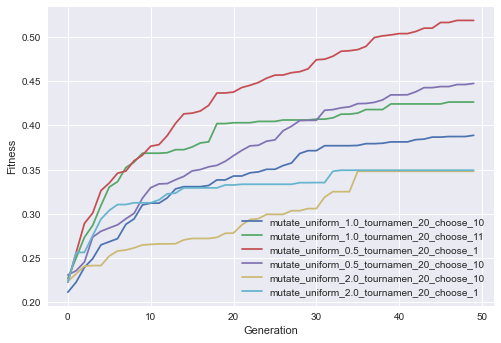

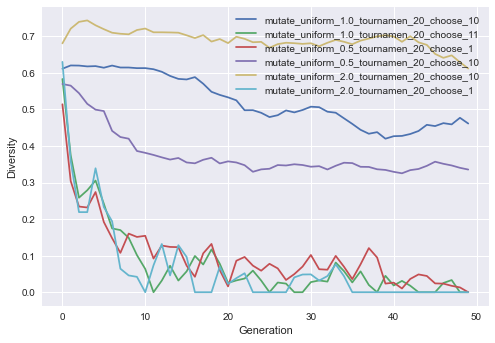

In [60]:
run_names = experiment_results.keys()
run_names = ["mutate_uniform_1.0_tournamen_20_choose_10","mutate_uniform_1.0_tournamen_20_choose_11",
             "mutate_uniform_0.5_tournamen_20_choose_1","mutate_uniform_0.5_tournamen_20_choose_10",
            "mutate_uniform_2.0_tournamen_20_choose_10", "mutate_uniform_2.0_tournamen_20_choose_1"]

plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = False)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = False)

### Q8b: Analysis
What patterns do you see?  Did you expect this given the implications of each independently?  Does the level of diversity match your intuition about how well search should perform?  Does this tell you anything about the role/interaction of variation (e.g. mutation rate) and selection (e.g. tournament parameters)?

**insert text here**

### Q9: Dynamic Mutation Rate
We talked in class about many way to have dynamic or adaptive mutation rates.  Let's experiment with the simplest form of this, a mutation rate that changes linearly over generational time, from some provided starting value to some provided ending value.  Please modify your evolutionary algorithm code below to enable this.

In [62]:
def evolutionary_algorithm(fitness_function=None, total_generations=100, num_parents=10, num_children=10, genome_length=10, num_elements_to_mutate=1, mutation_size_start=1.0, mutation_size_end = 0.1, crossover=True, tournament_size=4, num_tournament_winners=2):
    """ Evolutinary Algorithm (copied from the basic hillclimber in our last assignment)
        
        parameters: 
        fitness_funciton: (callable function) that return the fitness of a genome 
                           given the genome as an input parameter (e.g. as defined in Landscape)
        total_generations: (int) number of total iterations for stopping condition
        num_parents: (int) the number of parents we downselect to at each generation (mu)
        num_childre: (int) the number of children (note: parents not included in this count) that we baloon to each generation (lambda)
        genome_length: (int) length of the genome to be evoloved
        num_elements_to_mutate: (int) number of alleles to modify during mutation (0 = no mutation)
        mutation_size_start: (float) scaling parameter of the magnitidue of mutations for floating point vectors at the beginning of search
        mutation_size_end: (float) scaling parameter of the magnitidue of mutations for floating point vectors at the end of search (note: if same as mutation_size_start, mutation rate is static, otherwise mutation rate is linearly interpolated between the two)
        crossover: (bool) whether to perform crossover when generating children 
        tournament_size: (int) number of individuals competing in each tournament
        num_tournament_winners: (int) number of individuals selected as future parents from each tournament (must be less than tournament_size)
        
        returns:
        fitness_over_time: (numpy array) track record of the top fitness value at each generation
        solutions_over_time: (numpy array) track record of the top genome value at each generation
        diversity_over_time: (numpy array) track record of the population genetic diversity at each generation
    """

    # initialize record keeping
    solution = None # best genome so far
    solution_fitness = -99999 # fitness of best genome so far
    best_accuracy = -99999 # fitness of best genome so far
    fitness_over_time = np.zeros(total_generations)
    solutions_over_time = np.zeros((total_generations,genome_length))
    diversity_over_time = np.zeros(total_generations)
    
    # the initialization proceedure
    population = [] # keep population of individuals in a list
    for i in range(num_parents): # only create parents for initialization (the mu in mu+lambda)
        population.append(Individual(fitness_function,genome_length)) # generate new random individuals as parents
    
    # get population fitness
    for i in range(len(population)):
        population[i].eval_fitness() # evaluate the fitness of each parent
    
    for generation_num in range(total_generations): # repeat
        
        # the modification procedure
        new_children = [] # keep children separate for now (lambda in mu+lambda)
        while len(new_children) < num_children:
            
            # inheretance
            [parent1, parent2] = np.random.choice(population, size=2) # pick 2 random parents
            child1 = copy.deepcopy(parent1) # initialize children as perfect copies of their parents
            child2 = copy.deepcopy(parent2)
            
            # crossover
            # N/A

            # mutation
            
            mutation_size = mutation_size_start - (mutation_size_start-mutation_size_end) * generation_num/total_generations
            
            for this_child in [child1,child2]:
#                 elements_to_mutate = np.random.rand(genome_length) < proportion_elements_to_mutate
                this_child.genome += (np.random.rand(genome_length)*2-1)* mutation_size #* elements_to_mutate
#                 this_child.genome += np.random.normal(loc = 0, scale = mutation_size, size = genome_length)
                this_child.genome = np.minimum(np.maximum(this_child.genome,-1),1)
        
            new_children.extend((child1,child2)) # add children to the new_children list
            
        # the assessement procedure
        for i in range(len(new_children)):
            new_children[i].eval_fitness() # assign fitness to each child 

        # selection procedure
        population += new_children # combine parents with new children (the + in mu+lambda)
#         tournament = sorted(population, key=lambda individual: individual.accuracy, reverse = True)
        population = sorted(population, key=lambda individual: individual.fitness, reverse = True) # sort the full population by each individual's fitness (from highers to lowest)
        
        # tournament selection
        new_population = []
        new_population.append(population[0])
        while len(new_population) < num_parents:
            tournament = np.random.choice(population, size = tournament_size)
#             tournament = sorted(tournament, key=lambda individual: individual.accuracy, reverse = True)
            tournament = sorted(tournament, key=lambda individual: individual.fitness, reverse = True)
            new_population.extend(tournament[:num_tournament_winners])    
        population = new_population
        
        # record keeping
        
        if population[0].fitness > solution_fitness: # if the new parent is the best found so far
            solution = population[0].genome                 # update best solution records
            solution_fitness = population[0].fitness
            solution_generation = generation_num
        fitness_over_time[generation_num] = solution_fitness # record the fitness of the current best over evolutionary time
        solutions_over_time[generation_num,:] = solution
        
        genome_list = np.array([individual.genome for individual in population])
        diversity = np.mean(genome_list.std(axis=0))
        diversity_over_time[generation_num] = diversity
                
#         print(generation_num, solution_fitness, best_accuracy, diversity)
        
    return fitness_over_time, solutions_over_time, diversity_over_time

### Q9b: Experimentation
Please peform a set of runs which decrease the mutation rate from `1.0` to `0.1` linearly over the 50 generations of search for a tournament of size `20` with `1` winner selected.  

In [65]:
num_runs = 5
total_generations = 50
genome_length = 14*14*10
proportion_elements_to_mutate = 1.0
mutation_size_start = 1.0
mutation_size_end = 0.1
num_parents = 50
num_children = 50
tournament_size = 20
num_tournament_winners = 1

for run_name in ["mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1"]:
    experiment_results[run_name] = np.zeros((num_runs, total_generations))
    solutions_results[run_name] = np.zeros((num_runs, total_generations, genome_length))
    diversity_results[run_name] = np.zeros((num_runs, total_generations))
    for run_num in range(num_runs):       
        start_time = time.time()
        fitness_over_time, solutions_over_time, diversity_over_time = evolutionary_algorithm(fitness_function=neural_network_fitness, total_generations=total_generations, num_parents=num_parents, num_children=num_children, genome_length=genome_length, proportion_elements_to_mutate=proportion_elements_to_mutate, mutation_size_start=mutation_size_start, mutation_size_end=mutation_size_end, tournament_size=tournament_size, num_tournament_winners=num_tournament_winners)
        experiment_results[run_name][run_num] = fitness_over_time
        solutions_results[run_name][run_num] = solutions_over_time
        diversity_results[run_name][run_num] = diversity_over_time
        print(run_name, run_num, time.time()-start_time, fitness_over_time[-1])

mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1 0 27.8985915184021 0.5229166666666667
mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1 1 28.80553102493286 0.57145
mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1 2 33.33502411842346 0.6272166666666666
mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1 3 31.962478399276733 0.5367
mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1 4 31.30536127090454 0.5362333333333333


### Q10: Visualize
Please plot (fitness and diversity of) the dynamic mutation rate against fixed mutation rates of `1.0` and `0.5` for the same tournament parameters. 

In [68]:
for i in experiment_results.keys():
    print(i)

mutate_uniform_1.0_tournamen_20_choose_5
mutate_uniform_1.0_tournamen_20_choose_10
mutate_uniform_1.0_tournamen_20_choose_11
mutate_uniform_2.0_tournamen_20_choose_10
mutate_uniform_2.0_tournamen_20_choose_1
mutate_uniform_0.5_tournamen_20_choose_1
mutate_uniform_0.5_tournamen_20_choose_10
mutate_uniform_0.5_tournamen_20_choose_5
mutate_uniform_2.0_tournamen_20_choose_5
mutate_uniform_0.1_tournamen_20_choose_1
mutate_uniform_0.1_tournamen_20_choose_5
mutate_uniform_0.1_tournamen_20_choose_10
mutate_uniform_ramp_1.0_to_0.1
mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1


plotting mutate_uniform_0.5_tournamen_20_choose_1
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_11
0
10
20
30
40
plotting mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1
0
10
20
30
40
plotting mutate_uniform_0.5_tournamen_20_choose_1
0
10
20
30
40
plotting mutate_uniform_1.0_tournamen_20_choose_11
0
10
20
30
40
plotting mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1
0
10
20
30
40


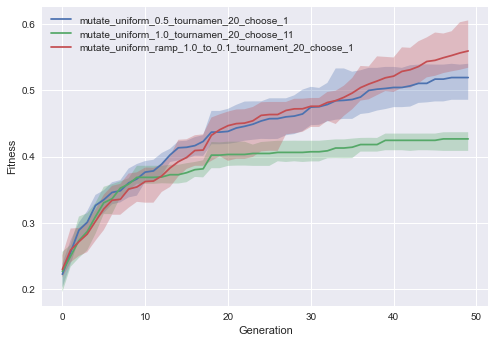

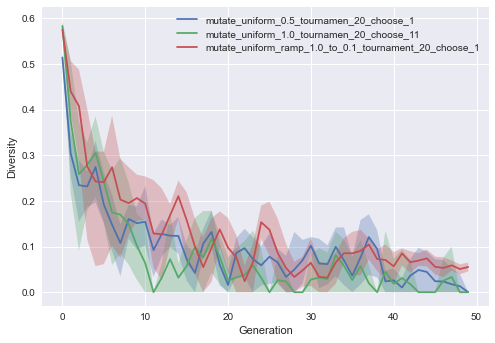

In [69]:
run_names = ["mutate_uniform_0.5_tournamen_20_choose_1", 
            "mutate_uniform_1.0_tournamen_20_choose_11",
            "mutate_uniform_ramp_1.0_to_0.1_tournament_20_choose_1"]
plot_mean_and_bootstrapped_ci_over_time(input_data = experiment_results, name = run_names, x_label = "Generation", y_label = "Fitness", plot_bootstrap = True)
plot_mean_and_bootstrapped_ci_over_time(input_data = diversity_results, name = run_names, x_label = "Generation", y_label = "Diversity", plot_bootstrap = True)

### Q10b: Analysis
What do you see?  Does the progress of the dynamic mutation rate track with what you expect given the fixed mutation rates?  Why or why not?  Talk especially about what happens near the end of search, realtive to what you might expect from that same time period in the case with a fixed mutation rate of `0.1` (feel free to run that experiment if you want, or just speculate based on those that you have run).  

**insert text here**

### Q11: Future Work
We've just begun to scratch the surface here.  What other experiments would be intersting to run?  What combinations of parameter interactions would be interesting?  What other approaches to dynamic/adaptive learning rates would be fun to implement?  Could you incorporate information about diversity in informing a dynamic learning rate -- what would that look like?

**insert text here**

### Congratulations, you made it to the end!
Nice work -- and hopefully you're starting to get the hang of these!

Please save this file as a .ipynb, and also download it as a .pdf, uploading **both** to blackboard to complete this assignment.  

For your submission, please make sure that you have renamed this file (and that the resulting pdf follows suit) to replce `[netid]` with your UVM netid.  This will greatly simplify our grading pipeline, and make sure that you receive credit for your work.  

#### Academic Integrity Attribution
During this assignment I collaborated with:

**insert text here**